## Introduction

In this project we will look at reinforcement learning (RL), which is a machine learning method that deals with  problems where we are trying to find an optimal way of maneuvering in an environment that can give rewards or penalties depending on our actions.


#### Q-Learning Theory and Implementation

In this reinforcement learning setup, we implement one-step Q-learning to find optimal policies in an environment. The agent interacts with the environment through actions, which transition the system between states and generate rewards.

The core objective is to maximize the cumulative discounted reward (return) $R_t=\sum_{t'=t}^\infty\gamma^{t'-t}r_{t'}$, where $\gamma$ is the discount factor weighing future versus immediate rewards.

The key component is the action-value function $Q(s,a)$, which represents the expected return when taking action $a$ in state $s$ and following the optimal policy thereafter. This can be expressed recursively as $Q(s,a)=r+\gamma\max_{a'}Q(s',a')$. The optimal policy simply selects actions that maximize $Q$ in each state.

To learn the Q-function through experience, we use an $\epsilon$-greedy exploration strategy:

1. In state $s$, choose the action $a$ that maximizes $Q(s,a)$ with probability $(1-\epsilon)$, or take a random action with probability $\epsilon$

2. Execute action $a$, observe the new state $s'$ and reward $r$

3. Update the Q-value estimate using:
   $Q(s,a)\leftarrow(1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
   where $\alpha$ is the learning rate

4. Continue from the new state $s'$, repeating until reaching a terminal state

The $\epsilon$ parameter balances exploitation of current knowledge versus exploration of new possibilities. With sufficient exploration and updates, this process converges to the optimal Q-function and corresponding optimal policy.

<b> I will construct an RL agent using one-step Q-learning to find the optimal path from start to finish in a "grid world". </b> The grid world is a rectangular board where the agent can move in the cardinal directions. The board is surrounded by sheer cliffs giving death and a large negative reward. There are also a "fire" on the board, which is not fatal but gives a large negative reward. In addition, to make things more intersting, there is a treacherous "wind" that can make you go in a completely unintended direction. Every step also gives a negative reward; you want to get to goal in as few steps as possible. Reaching goal gives the only positive reward available on the board. 

The grid will consist of squares of "fire" and a "goal". The edge of the grid will be considered a "cliff". The game ends if you end up at the goal, which will yield a reward of 100. The game also ends if you fall over the cliff resulting in a -100 reward. You can walk through fire, but it yields a negative reward of -50 for each step. Every other step yields a -1 reward, meaning that we want to find the shortest path to the goal.


In [3]:
# Setup grid 

import numpy as np
import matplotlib.pyplot as plt 

startpos=np.array([0,29])
goalpos=np.array([10,0])
size_grid_x=30
size_grid_y=40

# Setup Q matrix (size,size,4) matrix for the 4 actions up,down,left,right=0,1,2,3
Q=np.zeros((size_grid_x,size_grid_y,4))  

# the reward associated with each obstacle
reward_list = {'fire': -50 , 'cliff': -100, 'goal': 100 , 'start' : -1 , '-' : -1 }
# the status of the game: 1 meaning the game has ended, the agent has hit a terminal state
status_list = {'fire': -1 , 'cliff': 1, 'goal': 1 , 'start' : -1 , '-' : -1 }

Next we define a function that constructs the grid

In [73]:
# Make grid
def make_grid():

    # Add padding, add an extra row, accessible trough index -1
    grid = [['-' for y in range(size_grid_y+1)] for x in range(size_grid_x+1)]
    
    for x in range(size_grid_x+1):
        for y in range(size_grid_y+1):
            #goal
            if x==goalpos[0]  and y==goalpos[1] :
                # store object
                grid[x][y] = 'goal'

            #cliff
            if x==size_grid_x  or y==size_grid_y :
                grid[x][y] = 'cliff'
                
            #fires
            elif (3<= x <=10) and (3<= y <= 10):
                grid[x][y] = 'fire'
    
            elif x==startpos[0]  and y==startpos[1] :
                grid[x][y] = 'start'

    return grid


Define a helper that plots the world

In [24]:
# Plot grid, pass None if you do not want to print a path 
def dispGrid(grid,path):
    grid_RGB = np.ones((size_grid_x,size_grid_y,3))*0.7 # 
    
    if path is not None :
        for i,location in enumerate(path):
            grid_RGB[location[0],location[1],:] = np.array([0,0,0]) # black'P' #player
    
    for x in range(size_grid_x):
        for y in range(size_grid_y):
            
            if grid[x][y]=='goal':
                grid_RGB[x,y,:] = np.array([245/255,237/255,48/255]) # Yellow
                
            if grid[x][y]=='fire':
                grid_RGB[x,y,:] = np.array([203/255,32/255,40/255]) # Red '-' #pit    
   
            if grid[x][y]=='start':
                grid_RGB[x,y,:] = np.array([0/255,254/255,0/255]) # Green '-' #pit    
   
   
    
    return grid_RGB

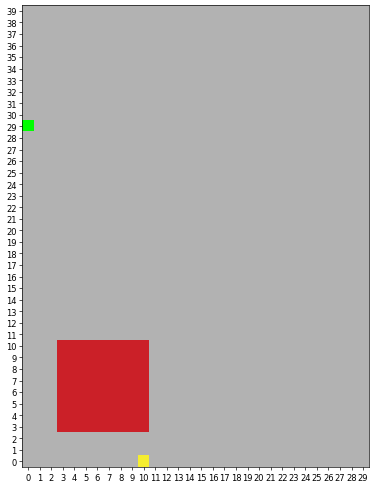

In [25]:
# make the grid
grid = make_grid()
# convert it to colors
plot_grid =dispGrid(grid,None)

fig=plt.figure(figsize=(10, 10), dpi= 60, facecolor='w', edgecolor='k')
# We have to invert the x and y axis , go over to numpy array instead
plt.imshow(np.swapaxes(np.array(plot_grid),0,1))
#plt.axis('on')
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, size_grid_x, dtype=int))
plt.yticks(np.arange(0, size_grid_y, dtype=int))
plt.show()

Here are the parameters for the Q-learning and for the environment (e.g wind)

In [128]:
# Define parameters to find find suitable values may take some thought and experimentation, 
# with the goal that the agent learns the best way to get from start to finish
alpha= 0.18 #learning rate <1, if big it will train quickly, but also forget old experiences 
gamma= 0.9 #discounting rate <=1, how many steps ahead does it need to see?
epsilon= 0.85 #for the epsilon-greedy policy, the agent starts with no knowledge so it needs to explore to learn 
            #might be useful to decrease this as the agent learns more

wind=0.1 # chance that action results in random move instead of intended action




$\alpha$ is set to 0.25, which results in slightly slower training by relying more on previous experiences compared to newly acquired experience. This value was determined through multiple runs, where a value of 0.25 yielded better paths compared to, for example, 0.6. However, there are trade-offs associated with both choices. A higher value of $\alpha$ relies more on new experiences, while a lower value stores more experiences but learns at a slower pace, thus requiring more time for training.

The selection of $\gamma$ as 0.9 allows the agent to consider both immediate and long-term rewards. With $\gamma$ set to 0.9, the agent assigns higher importance to long-term future rewards, opening up the possibility of discovering better paths in the long run as the grid is quite large.

The parameter $\epsilon$ represents the agent's level of greediness, determining the probability of exploring new options versus utilizing existing knowledge (q-values) to find paths. It is initialized as $\epsilon=0.85$ and gradually decreased by a factor of (1/number_of_games) in each iteration. As the game progresses, the agent increasingly relies on its existing knowledge and exploits the environment more, reducing its exploratory behavior.


- The function <code>action_fcn(q_in,epsilon,wind)</code> is designed to handle the agent's decision-making process. It takes as input 
<code>q_in , epsilon, wind</code> and produces <code> move, action</code> as output.

- The variable <code>q_in</code> represents the action values for the four different actions 0,1,2,3 (corresponding to up,down,left,right) in a state defined by the position of the agent. For instance, if <code> position </code> is the current state, then <code> q_in=Q(position[0],position[1],:)</code>.

- The output <code>action</code> is the action selected based on the epsilon greedy procedure, i.e. 0,1,2 or 3. This action is then mapped to a <code>move</code> that specifies how to update <code> position </code>. However, we also consider the effect of wind, which means that the actual move taken by the player should have a probability <code>wind</code> to be just a random move in any direction. Let <code>move</code> be the actual move performed when wind is taken into account. In other words, the agent will think it takes <code>action</code>, but it may actually take <code>move</code>, resulting in a different subsequent state and reward, than the agent intended.


In [83]:
def action_fcn(q_in,epsilon,wind):

    # all possible moves
    moves = [(0, 1), (0, -1), (-1, 0), (1, 0)]
    
    # probability if we should exploit or eplore the environment
    if np.random.rand() < 1 - epsilon:
        action = np.argmax(q_in) # max valued action
    else:
        action = np.random.randint(0,4) # random direction

    if action == 0:
        move = moves[0] # move up
    elif action == 1:
        move = moves[1] # move down
    elif action == 2:
        move = moves[2] # move left
    elif action == 3:
        move = moves[3] # move right

    # if there is wind, a random move is taken
    if np.random.rand() < wind:
        move = moves[np.random.randint(0,4)]

    return move, action




**How do epsilon and wind differ?**

Epsilon and wind differ in their effects on the agent's decision-making process. Epsilon represents a greedy-probability factor that guides the agent in choosing between exploiting or exploring the current environment. It is fully aware of the anticipated outcomes associated with each decision. On the contrary, wind introduces an element of unpredictability to the outcome, which is unknown to the agent. Although the agent may perceive its actions as exploitation or exploration, the presence of wind introduces randomness into the program and therefore may make the agent believe it took moves which it did not.

The next step is to implement the actual learning learning algorithm, which consists of playing the game many times and learn the Q-function. To train the agent loop through a big number of games. Run each game until you go outside the grid, the 'cliff', or if you reach the goal. 

This training can be done in several steps, possible using different training parameters, epsilon, gamma, and alpha. 

In [130]:
# loop over games
nr_of_games=20000

for game in range(nr_of_games):
    # Initilize the player at the start position and store the current position in position
    position=startpos
    status = -1
    
    while status == -1:

        # the current action value
        q_in = Q[position[0]][position[1]] 

        # generate a move and an action 
        move, action = action_fcn(q_in,epsilon,wind)  
        
        # save the prev positions for reward calculations, and also moving to new position
        prev_pos = position  
        position = position + move 
        
        # update the grid and status with the new position
        updated_grid = grid[position[0]][position[1]] 
        status = status_list[updated_grid]
        
        # new reward with new status
        reward = reward_list[updated_grid] 
         
        if status == 1:
            # the new q_value is just the reward as the game terminates

            q_reward = alpha * reward + (1 - alpha) * Q[prev_pos[0], prev_pos[1], action]
                                                                           
            Q[prev_pos[0], prev_pos[1], action] = q_reward
        else:
            # the q_value estimate using the formula
            q_estimate = alpha * (reward + gamma * np.max(Q[position[0], position[1], :]))
            q_prev = Q[prev_pos[0],prev_pos[1], action]
            
            Q[prev_pos[0],prev_pos[1],action] =  q_prev * (1 - alpha)  +  q_estimate
                                            
    
    # reduce epsilon for more exploitation after many runs
    epsilon -= 1 / nr_of_games
    
    if game % 1000 == 0:
        print(f'game nr: {game}, Q_max:{np.max(Q)},  Q_min:{np.min(Q)}')

game nr: 0, Q_max:0.0,  Q_min:-18.0
game nr: 1000, Q_max:0.0,  Q_min:-99.7969365399078
game nr: 2000, Q_max:18.0,  Q_min:-99.94692055287842
game nr: 3000, Q_max:69.59933285760002,  Q_min:-99.99850866320376
game nr: 4000, Q_max:90.75799437297003,  Q_min:-99.99827159804578
game nr: 5000, Q_max:99.54130095860727,  Q_min:-99.99993452856657
game nr: 6000, Q_max:92.12247990822951,  Q_min:-99.99850866320376
game nr: 7000, Q_max:99.99999421009106,  Q_min:-99.97628059694887
game nr: 8000, Q_max:99.9355745416421,  Q_min:-99.99538372274897
game nr: 9000, Q_max:99.74946673552338,  Q_min:-99.99960067776244
game nr: 10000, Q_max:99.94394606869582,  Q_min:-99.99726381445376
game nr: 11000, Q_max:99.95600182554641,  Q_min:-99.9997471215779
game nr: 12000, Q_max:99.32088402033918,  Q_min:-99.99902931443502
game nr: 13000, Q_max:99.90270130395608,  Q_min:-99.99871376980825
game nr: 14000, Q_max:97.4633357497273,  Q_min:-99.99929081383165
game nr: 15000, Q_max:94.76703653021694,  Q_min:-99.99941846734195


The value function V(s) represents the highest Q-value for each state-action pair in Q(s, a), regardless of the specific action taken (as there are four different actions).

/var/folders/ym/s4qttynd2r50zpqn0tx9c7w00000gn/T/ipykernel_97283/2083018983.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.xticks(np.arange(0, size_grid_x, dtype=np.int))
/var/folders/ym/s4qttynd2r50zpqn0tx9c7w00000gn/T/ipykernel_97283/2083018983.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

<Figure size 640x480 with 0 Axes>

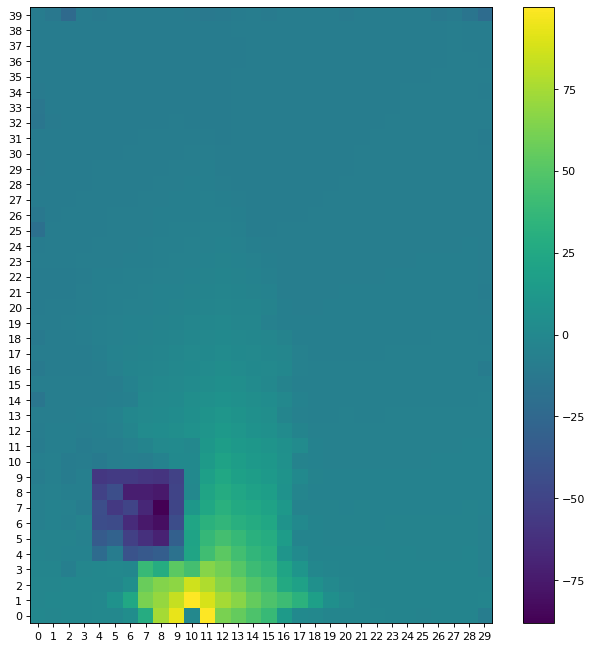

In [131]:
#Value function
z=Q.max(axis=2)
#z=z.T
#z=np.flip(z,axis=0)
#z=np.flip(z,axis=1)
plt.figure()
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(np.swapaxes(z,0,1))
plt.colorbar()
#plt.grid(False)
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, size_grid_x, dtype=np.int))
plt.yticks(np.arange(0, size_grid_y, dtype=np.int))
plt.show()


The best path can be determined by analyzing the state values V(s) plot. The best path is characterized by following the brightest squares, which represent the highest rewards, and avoiding the dark squares, which indicate termination and the lowest reward. This strategy ensures that the path leads to the treasure by following the highest rewards and avoids termination by steering clear of the lowest rewards.

In [132]:
#a path
location=startpos
path=np.array([startpos])
reaction=0
step_count=0;
while reaction !=1:
    q_state=Q[location[0],location[1],:]
    step_count+=1
    move, action = action_fcn(q_state,0.0,0.0)  #take optimal move
    location_new=location+move

    obstacle = grid[location_new[0]][location_new[1]]       
    reaction = status_list[obstacle]
    
    location=location_new
    
    path=np.append(path,[location],axis=0)
    if step_count>100:
        break
print(path,step_count)



[[ 0 29]
 [ 1 29]
 [ 2 29]
 [ 2 28]
 [ 3 28]
 [ 3 27]
 [ 3 26]
 [ 4 26]
 [ 5 26]
 [ 5 25]
 [ 5 24]
 [ 5 23]
 [ 6 23]
 [ 7 23]
 [ 8 23]
 [ 9 23]
 [ 9 22]
 [10 22]
 [10 21]
 [10 20]
 [11 20]
 [11 19]
 [12 19]
 [12 18]
 [12 17]
 [12 16]
 [12 15]
 [12 14]
 [12 13]
 [12 12]
 [12 11]
 [12 10]
 [12  9]
 [12  8]
 [12  7]
 [12  6]
 [12  5]
 [12  4]
 [12  3]
 [12  2]
 [11  2]
 [11  1]
 [10  1]
 [10  0]] 43


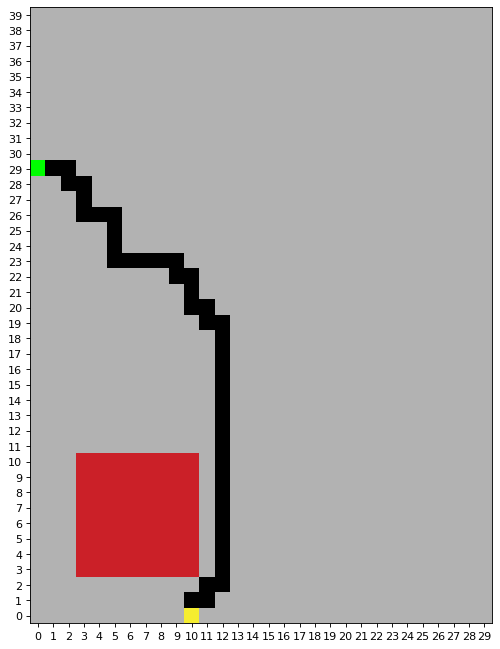

In [133]:
#plot above path
grid = make_grid()
plot_grid = dispGrid(grid,path)

fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
# We have to invert the x and y axis , go over to numpy array instead
plt.imshow(np.swapaxes(np.array(plot_grid),0,1))
#plt.axis('on')
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, size_grid_x, dtype=int))
plt.yticks(np.arange(0, size_grid_y, dtype=int))
plt.show()